In [6]:
import os
import rasterio
import numpy as np
from sklearn.decomposition import PCA, KernelPCA
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


/home/biswajitrana/.local/lib/python3.10/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


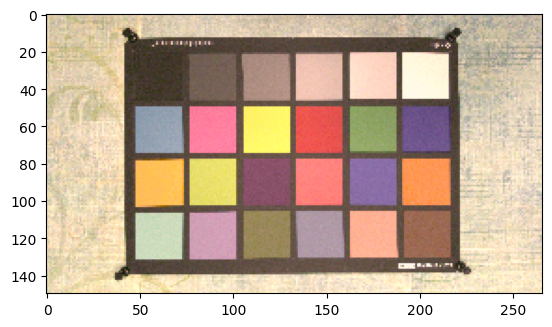

<Axes: >

In [2]:
import rasterio
from rasterio.plot import show

# Define the path to the image file
image_path = '/home/biswajitrana/Downloads/Data/Noisy_Data/0003_NOISY_SRGB_010.PNG'  # Change the file format accordingly

# Define the desired matrix size
desired_width = 266
desired_height = 150

# Open the image file with the desired size
with rasterio.open(image_path) as src:
    # Read the image data with the specified size
    image = src.read(
        out_shape=(src.count, desired_height, desired_width),
        resampling=rasterio.enums.Resampling.nearest
    )

# Plot the image
show(image)


In [8]:
image = plt.imread("/home/biswajitrana/Downloads/Data/Noisy_Data/0003_NOISY_SRGB_010.PNG", plt.IMREAD_GRAYSCAL)

AttributeError: module 'matplotlib.pyplot' has no attribute 'IMREAD_GRAYSCAL'

In [15]:
image.shape

(3, 3000, 5328)

In [16]:
flattened_image = image.reshape(3, -1)

In [17]:
flattened_image.shape

(3, 15984000)

In [20]:
pca = PCA(n_components=2, random_state=42)

In [21]:
pca.fit(flattened_image)

: 

In [ ]:
X_reconstructed_pca = pca.inverse_transform(pca.transform(flattened_image))

In [ ]:
print(X_reconstructed_pca.shape)

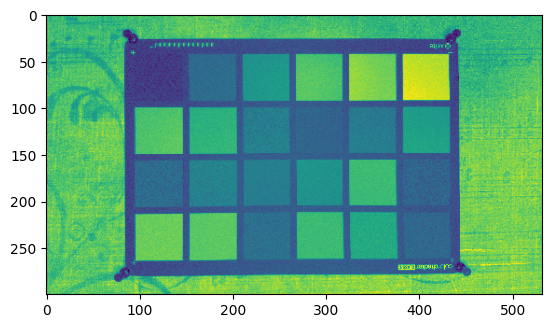

<Axes: >

In [16]:
show(image[2,:,:])

In [12]:
image.shape

(3, 300, 532)

In [9]:

# Directory containing the images
directory = "/home/biswajitrana/Downloads/Data/Noisy_Data/"

# List to store matrices of all images
image_matrices = []

# Iterate through each image file
for filename in os.listdir(directory):
    if filename.endswith(".PNG"):  # Assuming images are in PNG format
        file_path = os.path.join(directory, filename)
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale mode
        if image is not None:
            image = cv2.resize(image, (532, 300))  # Resize image to (532, 300)
            image_matrices.append(image)

# Combine all matrices into a single array if there are images
if image_matrices:
    combined_array = np.stack(image_matrices)
    # Verify shape of the combined array
    print("Shape of Combined Array:", combined_array.shape)
else:
    print("No images found or all images failed to process.")



Shape of Combined Array: (320, 300, 532, 3)


In [13]:
flattened_combined_arr = combined_array.reshape(320, -1, 3)

# Verify the shape of the reshaped matrix
print("Shape of the reshaped matrix:", flattened_combined_arr.shape)

Shape of the reshaped matrix: (320, 159600, 3)


In [17]:
extracted_matrix = flattened_combined_arr[:, :, 0]

# Save the remaining dimensions into another matrix
other_matrix = flattened_combined_arr[:, :, 1:]

# Verify the shapes of the extracted and other matrices
print("Shape of extracted_matrix:", extracted_matrix.shape)
print("Shape of other_matrix:", other_matrix.shape)

Shape of extracted_matrix: (320, 159600)
Shape of other_matrix: (320, 159600, 2)


In [18]:
extracted_matrix.shape

(320, 159600)

In [2]:
import numpy as np

class KernelPCA:
    def __init__(self, n_components, kernel='linear', gamma=None):
        self.n_components = n_components
        self.kernel = kernel
        self.gamma = gamma
        
    def fit(self, X):
        n_samples, n_features = X.shape
        
        # Centering the data
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        # Compute the kernel matrix
        if self.kernel == 'linear':
            self.kernel_matrix = np.dot(X_centered, X_centered.T)
        elif self.kernel == 'rbf':
            if self.gamma is None:
                self.gamma = 1 / n_features  # Default gamma
            self.kernel_matrix = self._rbf_kernel(X, X)
        else:
            raise ValueError("Invalid kernel type. Supported kernels are 'linear' and 'rbf'.")
        
        # Centering the kernel matrix
        mean_row = np.mean(self.kernel_matrix, axis=0)
        mean_col = np.mean(self.kernel_matrix, axis=1)
        mean_all = np.mean(self.kernel_matrix)
        self.kernel_matrix_centered = self.kernel_matrix - mean_row - mean_col + mean_all
        
        # Eigen decomposition
        eig_values, eig_vectors = np.linalg.eigh(self.kernel_matrix_centered)
        
        # Sort eigenvalues and eigenvectors
        idx = np.argsort(eig_values)[::-1]
        self.eigenvalues = eig_values[idx]
        self.eigenvectors = eig_vectors[:, idx]
        
        # Select top k eigenvectors
        self.components_ = self.eigenvectors[:, :self.n_components]
        
    def transform(self, X):
        X_centered = X - self.mean
        if self.kernel == 'linear':
            return np.dot(X_centered, self.components_)
        elif self.kernel == 'rbf':
            return self._rbf_kernel(X, X_centered)
    
    def _rbf_kernel(self, X1, X2):
        pairwise_sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
        return np.exp(-self.gamma * pairwise_sq_dists)

# Example usage:
if __name__ == "__main__":
    # Generate some sample data
    np.random.seed(0)
    X = np.random.rand(10, 2)
    
    # Perform Kernel PCA
    kpca = KernelPCA(n_components=1, kernel='rbf', gamma=0.1)
    kpca.fit(X)
    X_kpca = kpca.transform(X)
    
    print("Original data shape:", X.shape)
    print("Transformed data shape:", X_kpca.shape)


Original data shape: (10, 2)
Transformed data shape: (10, 10)


In [3]:
import numpy as np

# Set the number of samples and features
n_samples = 100
n_features = 2

# Generate X1 with random values
X1 = np.random.rand(n_samples, n_features)

# Generate X2 with random values
X2 = np.random.rand(n_samples, n_features)

print("X1 shape:", X1.shape)
print("X2 shape:", X2.shape)


X1 shape: (100, 2)
X2 shape: (100, 2)


In [20]:
np.sum(X1**2,axis=1).reshape(-1, 1).shape

(100, 1)

In [13]:
np.sum(X2**2, axis=1).shape

(100,)

In [19]:
(np.sum(X1**2,axis=1).reshape(-1, 1)+np.sum(X2**2, axis=1)-2*np.dot(X1, X2.T)).shape

(100, 100)

In [ ]:
def _rbf_kernel(self, X1, X2):
    pairwise_sq_dists = np.sum(X1**2, axis=1).reshape(-1, 1) + np.sum(X2**2, axis=1) - 2 * np.dot(X1, X2.T)
    return np.exp(-self.gamma * pairwise_sq_dists)